# Dentate Gyrus

The dataset used in here for velocity analysis is from the dentate gyrus, a part of the hippocampus which is involved in learning, episodic memory formation and spatial coding. 

It is measured using 10X Genomics Chromium and described in [Hochgerner et al. (2018)](https://www.nature.com/articles/s41593-017-0056-2). The data consists of 25,919 genes across 2,930 cells forming multiple lineages.

In [1]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.0 (python 3.7.3) on 2020-05-13 09:25.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

### Load and cleanup the data

The following analysis is based on the in-built [dentate gyrus dataset](https://scvelo.readthedocs.io/scvelo.datasets.dentategyrus.html#scvelo.datasets.dentategyrus).

To run velocity analysis on your own data, read your file (loom, h5ad, xlsx, csv, tab, txt …) to an AnnData object with `adata = scv.read('path/file.loom', cache=True)`.

If you want to merge your loom file into an already existing AnnData object, use `scv.utils.merge(adata, adata_loom)`.

In [3]:
adata = scv.datasets.dentategyrus()

In [4]:
# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.9 0.1]


AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

If you have a very large datasets, you can save memory by clearing attributes not required via `scv.utils.cleanup(adata)`.

### Preprocess the data

Preprocessing that is necessary consists of :
- gene selection by **detection** (detected with a minimum number of counts) and **high variability** (dispersion).
- **normalizing** every cell by its initial size and **logarithmizing** X.

Filtering and normalization is applied in the same vein to spliced/unspliced counts and X.
Logarithmizing is only applied to X. If X is already preprocessed from former analysis, it won't touch it.

All of this is summarized in a single function `pp.filter_and_normalize`, which basically runs the following:

```
scv.pp.filter_genes(adata, min_shared_counts=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)
scv.pp.log1p(adata)
```

Further, we need the first and second order moments (basically mean and uncentered variance) computed among nearest neighbors in PCA space. 
First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 11019 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


### Compute velocity and velocity graph
The gene-specific velocities are obtained by fitting a ratio between precursor (unspliced) and mature (spliced) mRNA abundances that well explains the steady states (constant transcriptional state) and then computing how the observed abundances deviate from what is expected in steady state. (We will soon release a version that does not rely on the steady state assumption anymore).

Every tool has its plotting counterpart. The results from `scv.tl.velocity`, for instance, can be visualized using `scv.pl.velocity`.

In [6]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


This computes the (cosine) correlation of potential cell transitions with the velocity vector in high dimensional space.
The resulting velocity graph has dimension $n_{obs} \times n_{obs}$ and summarizes the possible cell state changes (given by a transition from one cell to another) that are well explained through the velocity vectors. If you set `approx=True` it is computed on a reduced PCA space with 50 components. 

The velocity graph can then be converted to a transition matrix by applying a Gaussian kernel on the cosine correlation which assigns high probabilities to cell state changes that correlate with the velocity vector. You can access the Markov transition matrix via `scv.tl.transition_matrix`. The resulting transition matrix can be used for a variety of applications shown hereinafter. For instance, it is used to place the velocities into a low-dimensional embedding by simply applying the mean transition with respect to the transition probabilities, i.e. `scv.tl.velocity_embedding`. Further, we can trace cells back along the Markov chain to their origins and potential fates, thus obtaining root cells and end points within a trajectory; via `scv.tl.terminal_states`.

In [7]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Plot results

Finally, the velocities are projected onto any embedding specified in `basis` and visualized in one of three available ways: on single cell level, on grid level, or as streamplot as shown here.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


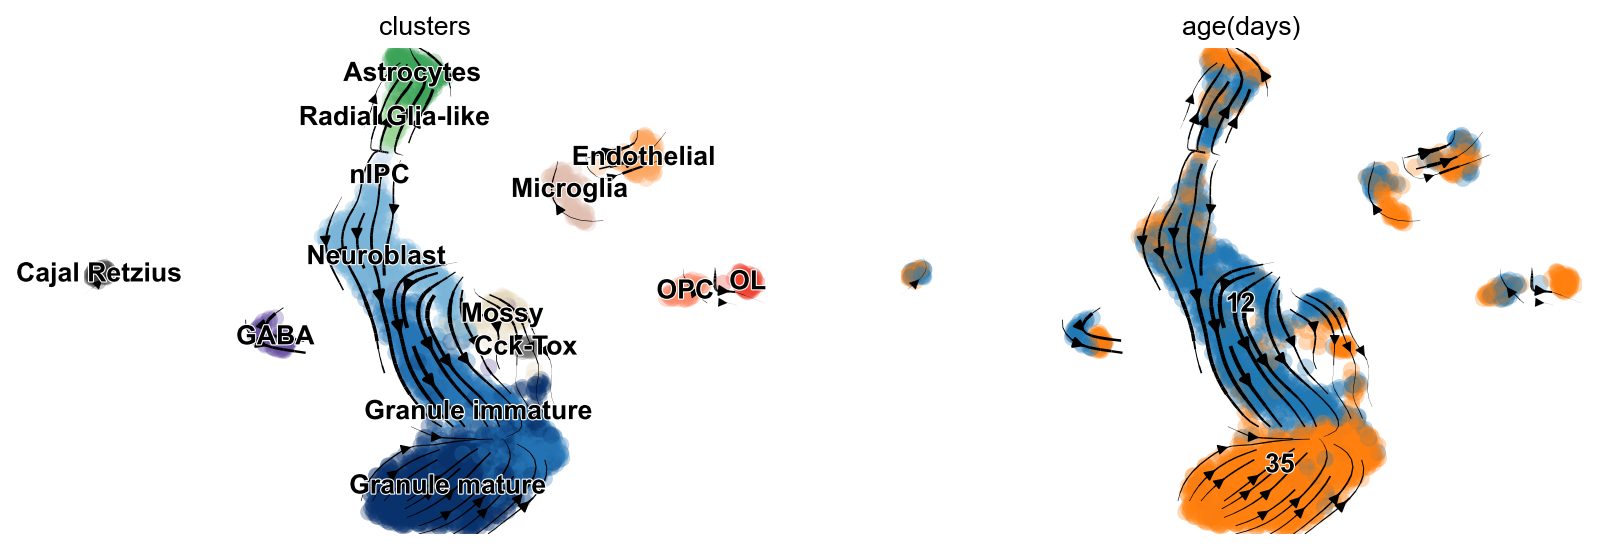

In [8]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['clusters', 'age(days)'])


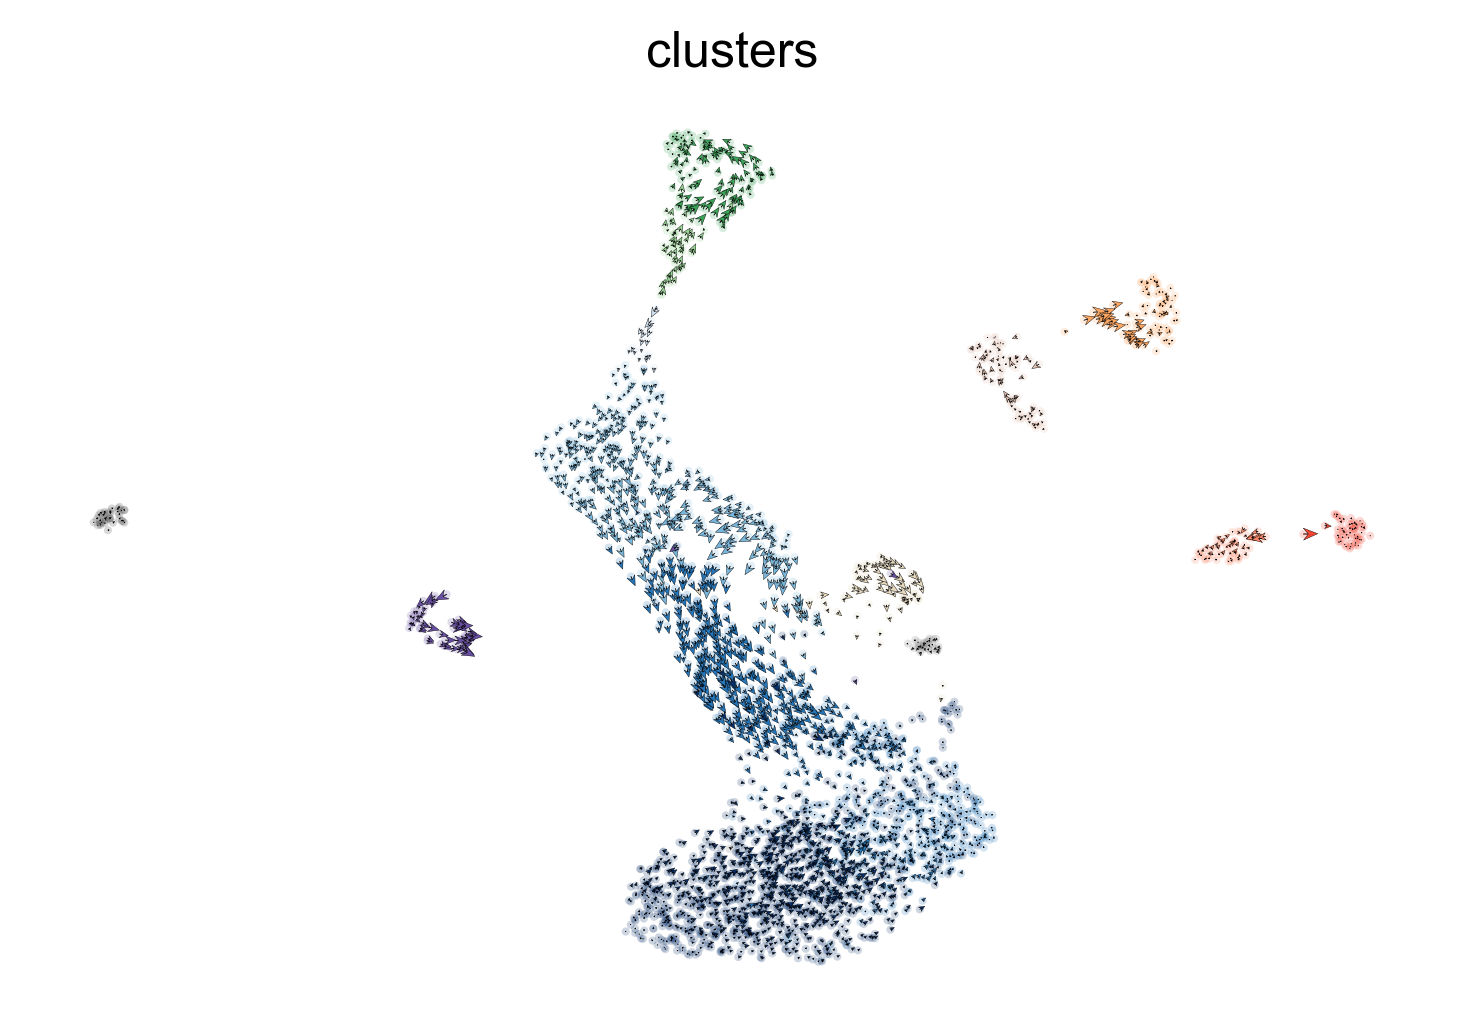

In [9]:
scv.pl.velocity_embedding(adata, basis='umap', arrow_length=2, arrow_size=2, dpi=150)


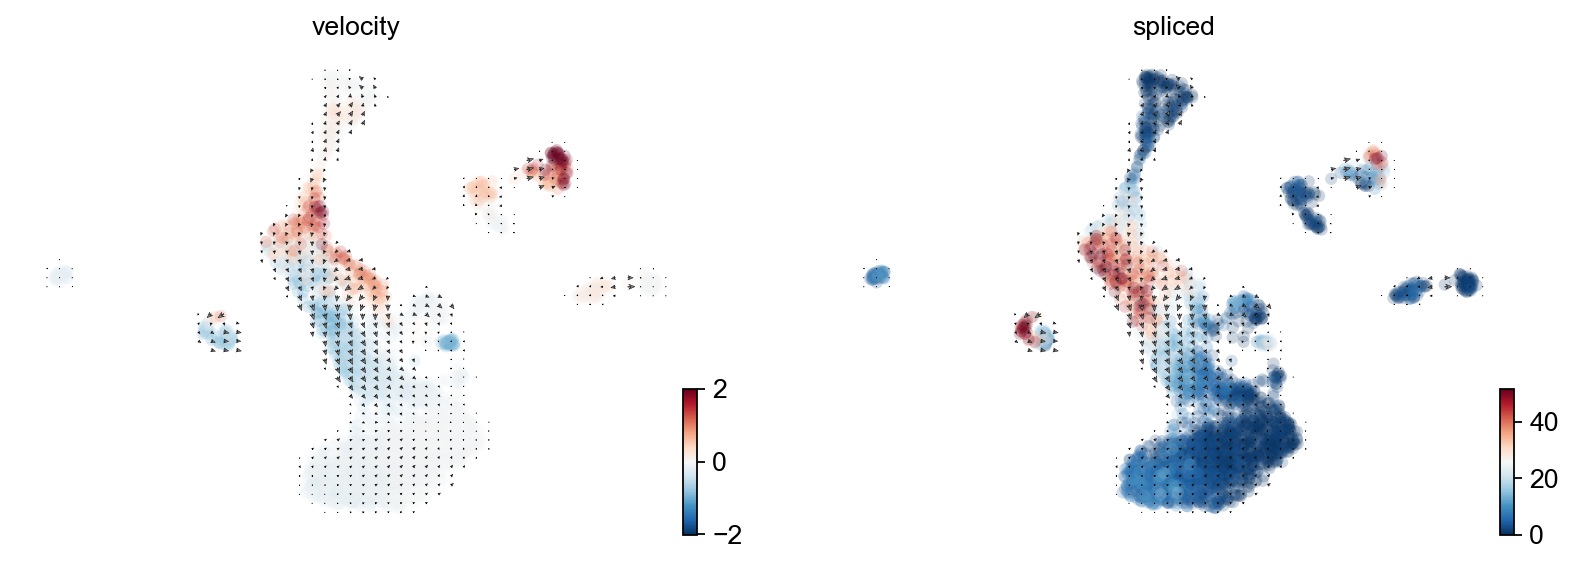

In [10]:
scv.pl.velocity_embedding_grid(adata, color='Tmsb10', 
                               layer=['velocity', 'spliced'], arrow_size=1.5)

In [11]:
scv.tl.rank_velocity_genes(adata, groupby='clusters')

scv.DataFrame(adata.uns['rank_velocity_genes']['names']).head()

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Astrocytes,Cajal Retzius,Cck-Tox,Endothelial,GABA,Granule immature,Granule mature,Microglia,Mossy,Neuroblast,OL,OPC,Radial Glia-like,nIPC
0,Phkg1,Utrn,Golga7b,Serpine2,Stmn2,Shisa9,Grasp,Srgap2,Chgb,Mt3,Clmn,Tnr,2810459M11Rik,Bzw2
1,Ctnnd2,Scg3,Irf9,Arhgap31,Vsnl1,Jph1,2010300C02Rik,Clic4,Pgm2l1,Gdpd1,Gprc5b,Hmgcs1,Ctnnd2,Igfbpl1
2,Lsamp,Tmem47,Cplx2,Tmsb10,Lancl1,Sphkap,Rtn4rl1,Qk,Fxyd1,Slc38a2,Arrdc3,Luzp2,Hepacam,Rps27l
3,Qk,Dpysl3,Stmn2,Igf1r,Mtus2,Pgbd5,Wasf1,Ssh2,Mapk6,Bzw2,Pcdh9,Elavl3,Ptn,Tbrg4
4,Cspg5,Sh3glb1,Nfkbia,Prex2,Elavl3,Pip5k1b,Jph1,Sirt2,Osbpl6,Epha4,Gatm,Ppp1r14c,Lsamp,Mpzl1


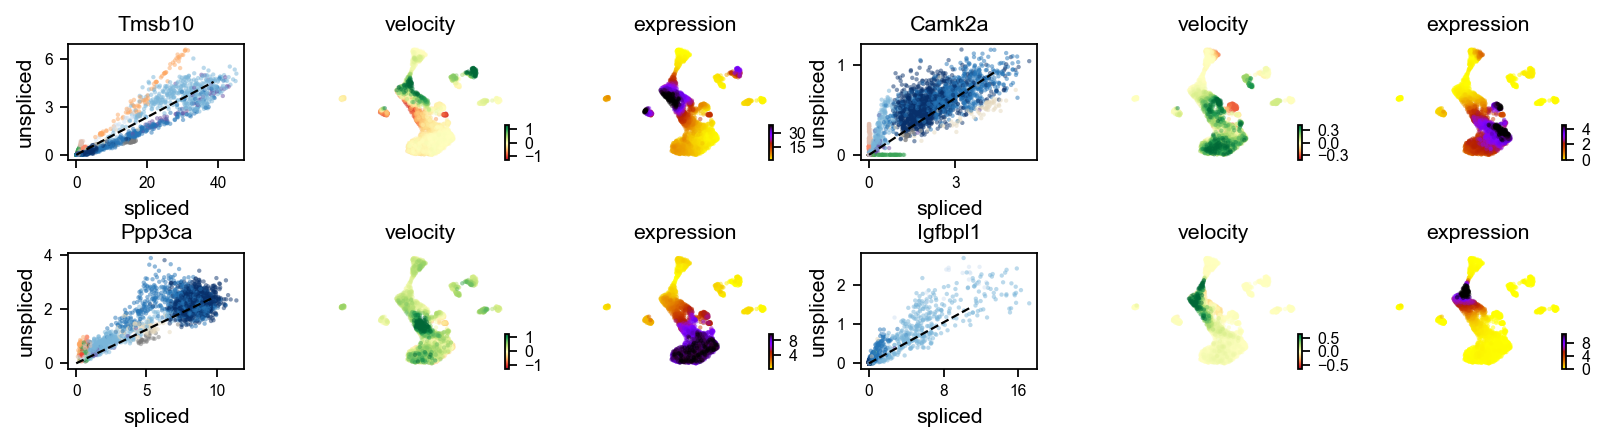

In [12]:
var_names = ['Tmsb10', 'Camk2a', 'Ppp3ca', 'Igfbpl1']
scv.pl.velocity(adata, var_names=var_names, colorbar=True, ncols=2)

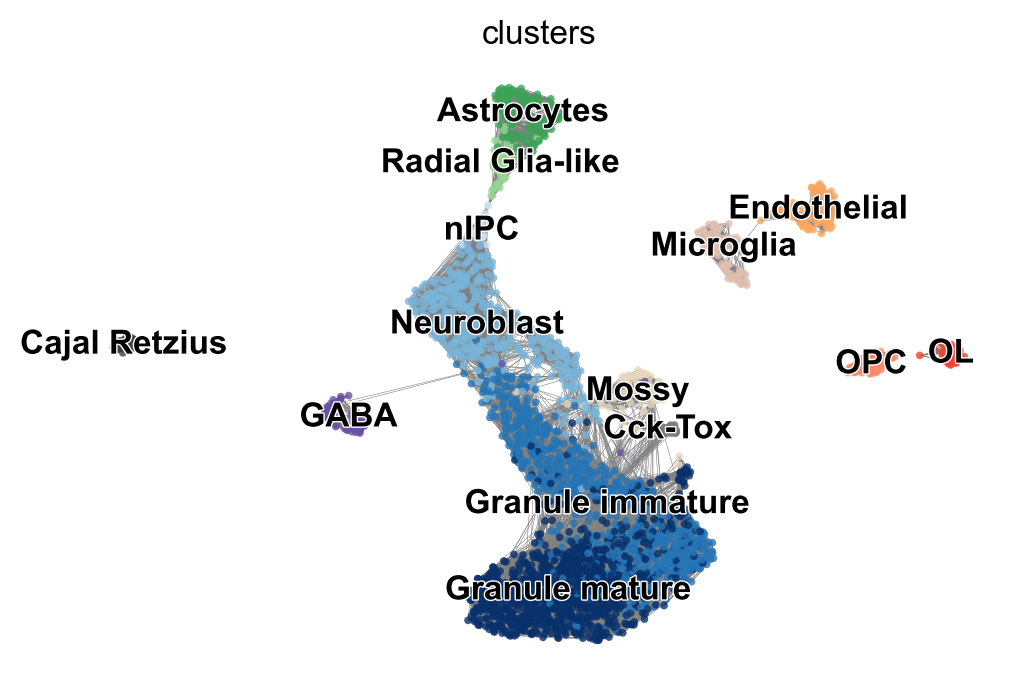

In [13]:
scv.pl.velocity_graph(adata)